In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from constants import LOCATION_CHOOSEN, INPUT_DIR, OUTPUT_DIR, DATA_CACHE_DIR, STRINGENCY_BASED_GDP

data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + ".csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel(os.path.join(INPUT_DIR, "owid-covid-data.xlsx"))
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

print(f'All columns in dataset: {df.columns}')

All columns in dataset: Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinati

In [2]:
df = df[["date", "stringency_index", "total_cases", "total_deaths", "total_vaccinations", "population", "people_fully_vaccinated"]]

def print_missing_stats(df, title):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    print(f'{title}: \n{missing_value_df}')


print_missing_stats(df, "Before preprocessing")

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.interpolate(method='time', inplace=True)

print_missing_stats(df, "After interpolation")

df.ffill(inplace=True)
df.bfill(inplace=True)

print_missing_stats(df, "After complete preprocessing")

Before preprocessing: 
                                     column_name  percent_missing
date                                        date         0.000000
population                            population         0.000000
total_cases                          total_cases         2.255109
total_deaths                        total_deaths         5.285412
stringency_index                stringency_index        22.903453
total_vaccinations            total_vaccinations        28.541226
people_fully_vaccinated  people_fully_vaccinated        30.655391
After interpolation: 
                                     column_name  percent_missing
stringency_index                stringency_index         0.000000
population                            population         0.000000
total_cases                          total_cases         1.902748
total_deaths                        total_deaths         4.933051
total_vaccinations            total_vaccinations        26.638478
people_fully_vaccinated  people

In [3]:
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated
date,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-04,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-05,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-06,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-07,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
...,...,...,...,...,...,...
2023-11-17,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986588.0
2023-11-18,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986616.0
2023-11-19,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986658.0


In [4]:
mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_24112023074356372.csv"))
print(f'MEI data columns: {mei_data.columns}')
print(f'MEI data subjects: {mei_data["Subject"].unique()}')
print(f'MEI data locations: {mei_data["LOCATION"].unique()}')

MEI data columns: Index(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure',
       'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit',
       'PowerCode Code', 'PowerCode', 'Reference Period Code',
       'Reference Period', 'Value', 'Flag Codes', 'Flags'],
      dtype='object')
MEI data subjects: ['Leading Indicators OECD > Component series > Bank activity > Normalised'
 'Leading Indicators OECD > Component series > Bank activity > Original series'
 'Leading Indicators OECD > Component series > BTS - Sales expectations > Normalised'
 'Leading Indicators OECD > Component series > BTS - Sales expectations > Original series'
 'Leading Indicators OECD > Component series > BTS - Demand or orders inflow > Normalised'
 'Leading Indicators OECD > Component series > BTS - Demand or orders inflow > Original series'
 'Leading Indicators OECD > Component series > BTS - Employment > Normalised'
 'Leading Indicators OECD > Component series > BTS - Employment > Original se

/tmp/ipykernel_9832/2505627277.py:1: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_24112023074356372.csv"))


In [5]:
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated
date,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-04,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-05,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-06,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
2020-01-07,0.0,1.0,1.0,0.000000e+00,1417173120,7668.0
...,...,...,...,...,...,...
2023-11-17,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986588.0
2023-11-18,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986616.0
2023-11-19,28.7,45001456.0,533295.0,2.206749e+09,1417173120,951986658.0


In [6]:
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")].columns)

Index(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure',
       'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit',
       'PowerCode Code', 'PowerCode', 'Reference Period Code',
       'Reference Period', 'Value', 'Flag Codes', 'Flags'],
      dtype='object')


In [7]:
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")][["TIME", "Value", "SUBJECT"]])

          TIME       Value   SUBJECT
23811  2016-01  100.242998  LORSGPNO
23812  2016-02  100.350121  LORSGPNO
23813  2016-03  100.449281  LORSGPNO
23814  2016-04  100.537791  LORSGPNO
23815  2016-05  100.613771  LORSGPNO
...        ...         ...       ...
23895  2023-01  100.504360  LORSGPNO
23896  2023-02  100.683176  LORSGPNO
23897  2023-03  100.867029  LORSGPNO
23898  2023-04  101.054082  LORSGPNO
23899  2023-05  101.242887  LORSGPNO

[89 rows x 3 columns]


In [8]:
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")]["SUBJECT"].unique())

['LORSGPNO']


In [9]:
def merge_data(df, mei_data, subject_selected):
    df_gdp = mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == subject_selected) & (mei_data["SUBJECT"] == "LORSGPNO")]
    print(subject_selected, df_gdp.shape[0])
    """
    if subject_based_data.shape[0] > 0:
        subject_based_data.loc[:, 'TIME'] = pd.to_datetime(subject_based_data['TIME'])
        print(subject_based_data['TIME'].unique())
        merged_df = pd.merge(df, subject_based_data[['TIME', 'Value']], left_on='date', right_on='TIME', how='inner')
        merged_df.drop(columns=['TIME'], inplace=True)
        merged_df.rename(columns={'Value': "".join(subject_selected.split(">")[2:])}, inplace=True)
        df = merged_df
        return df
    """
    if df_gdp.shape[0] > 0:
        df_gdp.rename(columns={'TIME': 'date'}, inplace=True)
        df_gdp['date'] = pd.to_datetime(df_gdp['date'])
        df_gdp = df_gdp[['date', 'Value']]
        df_gdp.rename(columns={'Value': "gdp_normalized"}, inplace=True)
        print_missing_stats(df_gdp, "Before preprocessing")
        
        df_gdp.set_index('date', inplace=True)

        # Merge the two DataFrames
        df_merged = pd.concat([df, df_gdp], axis=1)
        
        # df_merged.interpolate(method='time', inplace=True)
        
        print("Min-max date before: ", df_merged.index.min(), df_merged.index.max())
        min_date = df.index.min()
        max_date = df.index.max()
        df_merged = df_merged[(df_merged.index >= min_date) & (df_merged.index <= max_date)]
        print("Min-max date before: ", df_merged.index.min(), df_merged.index.max())
        return df_merged

In [10]:
df_merged = merge_data(df, mei_data, "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")
df_merged

/tmp/ipykernel_9832/1800667369.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp.rename(columns={'TIME': 'date'}, inplace=True)
/tmp/ipykernel_9832/1800667369.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp['date'] = pd.to_datetime(df_gdp['date'])


Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised 89
Before preprocessing: 
                   column_name  percent_missing
date                      date              0.0
gdp_normalized  gdp_normalized              0.0
Min-max date before:  2016-01-01 00:00:00 2023-11-21 00:00:00
Min-max date before:  2020-01-03 00:00:00 2023-11-21 00:00:00


,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-04,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-05,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-06,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-07,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
...,...,...,...,...,...,...,...
2023-11-17,28.7,45001456.0,533295.0,2.206749e+09,1.417173e+09,951986588.0,NaN
2023-11-18,28.7,45001456.0,533295.0,2.206749e+09,1.417173e+09,951986616.0,NaN
2023-11-19,28.7,45001456.0,533295.0,2.206749e+09,1.417173e+09,951986658.0,NaN


In [11]:
df = df_merged
print(df.columns)

Index(['stringency_index', 'total_cases', 'total_deaths', 'total_vaccinations',
       'population', 'people_fully_vaccinated', 'gdp_normalized'],
      dtype='object')


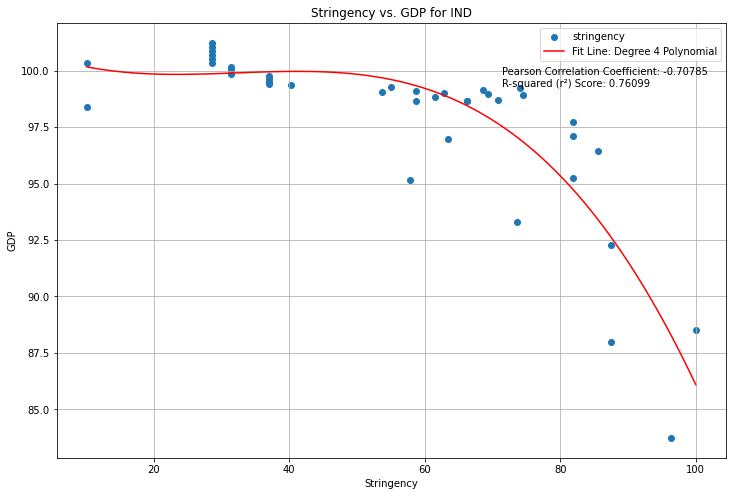

In [12]:
# df = df[(df['date'].dt.year == 2021) & (df['date'].dt.month >= 5) | (df['date'].dt.year == 2022)]
selected_dates = df[df['gdp_normalized'].notnull()].index
stringency = df.loc[selected_dates, 'stringency_index']
gdp = df.loc[selected_dates, 'gdp_normalized']

correlation_coefficient, _ = pearsonr(stringency, gdp)

fit_coefficients = np.polyfit(stringency, gdp, 3)
fit_line = np.poly1d(fit_coefficients)

np.save('stringency_based_gdp.npy', fit_line)

r2 = r2_score(gdp, fit_line(stringency))

plt.figure(figsize=(12, 8))
plt.scatter(stringency, gdp, label="stringency")

stringency_range = np.linspace(min(stringency), max(stringency), 100)  # Generating a range for the fitted line
plt.plot(stringency_range, fit_line(stringency_range), color='red', label=f'Fit Line: Degree 4 Polynomial')
plt.figtext(0.64, 0.77, f'\nPearson Correlation Coefficient: {correlation_coefficient:.5f}\nR-squared (r²) Score: {r2:.5f}')

plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [13]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_with_GDP.csv"), index=False)

86.41148240975596 101.1401733474542


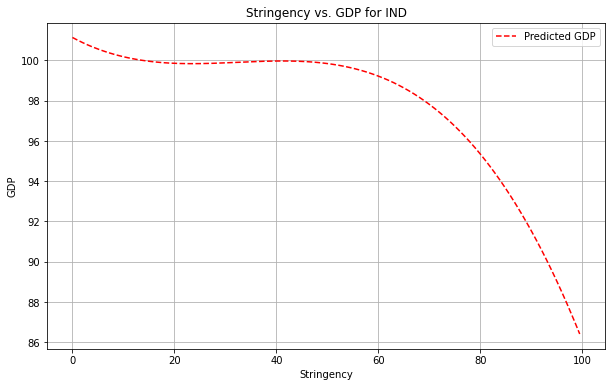

In [14]:
stringency_data_points = np.arange(0, 100, 0.5)
predicted_gdp = fit_line(stringency_data_points)

MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)
print(MIN_GDP, MAX_GDP)

plt.figure(figsize=(10, 6))
plt.plot(stringency_data_points, predicted_gdp, label="Predicted GDP", color='red', linestyle='--')
plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_extended_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [15]:
# check save and load
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
print(fit_line_loaded(100.0))

86.09640093040117


In [16]:
print(selected_dates)

DatetimeIndex(['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
              dtype='datetime64[ns]', name='date', freq=None)


In [17]:
df = df[(df.index <= '2023-05-01 00:00:00')]
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-04,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-05,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-06,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-07,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
...,...,...,...,...,...,...,...
2023-04-27,28.7,44924811.0,531424.0,2.206628e+09,1.417173e+09,951967433.0,NaN
2023-04-28,28.7,44932344.0,531468.0,2.206632e+09,1.417173e+09,951967524.0,NaN
2023-04-29,28.7,44939515.0,531508.0,2.206636e+09,1.417173e+09,951967704.0,NaN


In [18]:
initial_gdp = mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised") & (mei_data["TIME"] == '2020-01')][["TIME", "Value", "SUBJECT"]]
print(initial_gdp['Value'].item())

100.577792123094


In [19]:
display(df.loc[df.index == '2020-01-03 00:00:00', :])
df.loc[df.index == '2020-01-03 00:00:00', 'gdp_normalized'] = initial_gdp['Value'].item()
display(df)

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.0,1.0,1.0,0.0,1.417173e+09,7668.0,NaN


/tmp/ipykernel_9832/4284524741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index == '2020-01-03 00:00:00', 'gdp_normalized'] = initial_gdp['Value'].item()


,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.577792
2020-01-04,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-05,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-06,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-07,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
...,...,...,...,...,...,...,...
2023-04-27,28.7,44924811.0,531424.0,2.206628e+09,1.417173e+09,951967433.0,NaN
2023-04-28,28.7,44932344.0,531468.0,2.206632e+09,1.417173e+09,951967524.0,NaN
2023-04-29,28.7,44939515.0,531508.0,2.206636e+09,1.417173e+09,951967704.0,NaN


In [20]:
print(min(df["stringency_index"]))

0.0


In [21]:
df.interpolate(method='time', inplace=True)
display(df)

/tmp/ipykernel_9832/2063108421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='time', inplace=True)


,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.577792
2020-01-04,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.569366
2020-01-05,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.560939
2020-01-06,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.552512
2020-01-07,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.544086
...,...,...,...,...,...,...,...
2023-04-27,28.7,44924811.0,531424.0,2.206628e+09,1.417173e+09,951967433.0,101.217713
2023-04-28,28.7,44932344.0,531468.0,2.206632e+09,1.417173e+09,951967524.0,101.224006
2023-04-29,28.7,44939515.0,531508.0,2.206636e+09,1.417173e+09,951967704.0,101.230300


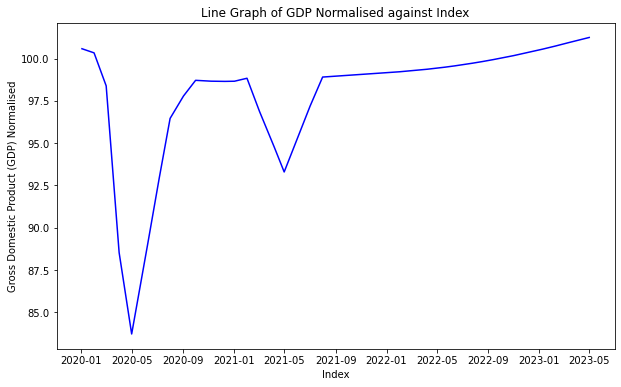

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df["gdp_normalized"], color='b')
plt.xlabel('Index')
plt.ylabel('Gross Domestic Product (GDP) Normalised')
plt.title('Line Graph of GDP Normalised against Index')
plt.show()

In [23]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))